In [5]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

from epa import *
from sample_processing import *
%load_ext autoreload
from gibbs_sampler import gibbs_sample_regression

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
%autoreload 2

In [7]:
np.random.seed(640)

# Load NSW Data

In [8]:
nsw_data = pd.read_csv('NSW_data.csv')

In [9]:
nsw_data['age_norm'] = (nsw_data['age'] - nsw_data['age'].mean())/nsw_data['age'].std()
nsw_data['educ_norm'] = (nsw_data['educ'] - nsw_data['educ'].mean())/nsw_data['educ'].std()
nsw_data['final_income'] = nsw_data['re78']/1000
nsw_data['re74_1000'] = nsw_data['re74']/1000
nsw_data['re75_1000'] = nsw_data['re75']/1000

nsw_data['re74_log'] = np.log(nsw_data['re74'].values+1)
nsw_data['re75_log'] = np.log(nsw_data['re75'].values+1)

In [10]:
nsw_data_employed = nsw_data[nsw_data['re78']>0]

In [11]:
nsw_data_employed['treat_age'] = (nsw_data_employed['treat'] * nsw_data_employed['age_norm']).copy()
nsw_data_employed['treat_educ'] = (nsw_data_employed['treat'] * nsw_data_employed['educ_norm']).copy()
nsw_data_employed['treat_black'] = (nsw_data_employed['treat'] * nsw_data_employed['black']).copy()
nsw_data_employed['treat_hisp'] = nsw_data_employed['treat'] * nsw_data_employed['hisp']
nsw_data_employed['treat_marr'] = nsw_data_employed['treat'] * nsw_data_employed['marr']
nsw_data_employed['treat_nodegree'] = nsw_data_employed['treat'] * nsw_data_employed['nodegree']
nsw_data_employed['treat_re74'] = nsw_data_employed['treat'] * nsw_data_employed['re74']
nsw_data_employed['treat_re75'] = nsw_data_employed['treat'] * nsw_data_employed['re75']

nsw_data_employed['treat_re74_log'] = nsw_data_employed['treat'] * nsw_data_employed['re74_log']
nsw_data_employed['treat_re75_log'] = nsw_data_employed['treat'] * nsw_data_employed['re75_log']

/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_51791/3460785187.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nsw_data_employed['treat_age'] = (nsw_data_employed['treat'] * nsw_data_employed['age_norm']).copy()
/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_51791/3460785187.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nsw_data_employed['treat_educ'] = (nsw_data_employed['treat'] * nsw_data_employed['educ_norm']).copy()
/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipy

In [12]:
data = nsw_data_employed
interact_effects = False

treatment = data['treat'].values
outcome = data['final_income'].values

covar_single = ['age','educ','black','hisp','marr','nodegree', 're74_log', 're75_log']
covar_interact = ['treat_age','treat_educ','treat_black',
                  'treat_hisp','treat_marr','treat_nodegree','treat_re74_log','treat_re75_log']

if interact_effects:
    covars = covar_single + covar_interact
else:
    covars = covar_single
#covars = ['age','educ','black','hisp', 'marr','nodegree']

# clustering covariates
cluster_set1 = ['age_norm','educ_norm','black','hisp','marr','nodegree']  # set 1 - all covariates
cluster_set2 = ['educ_norm','nodegree']  # set 2 - Education
cluster_set3 = ['age','black','hisp']  # set 2 - Education

In [13]:
reg_covariates = np.hstack([np.ones(len(treatment)).reshape(-1,1),
                            treatment.reshape(-1,1),
                            data[covars].values])

Zs = data[cluster_set1].values
# normalize Zs

Ys = outcome

# Calculate similarity matrix
tau = 0.5
lambda_matrix = pairwise_distances(X=Zs, metric=exp_sim_func, tau=tau)

In [14]:
# initialize partition with 3 clusters
partition_init = np.array([1]*104 + [2]*104 + [3]*100)

# Initialize phi
n_betas = reg_covariates.shape[1]
labels_used = list(np.unique([partition_init]))
phi_init = np.random.normal(0,1,(len(labels_used),n_betas))

# prior for phi
phi_mean_prior = np.zeros(n_betas)

phi_cov_prior =  np.eye(n_betas)
phi_cov_prior = np.array([[3., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                           [0., 2., 0., 0., 0., 0., 0., 0., 0., 0.],
                           [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
                           [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
                           [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
                           [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
                           [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
                           [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
                           [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
                           [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [15]:
n_burn_in=5000

covar_set2_outputs = gibbs_sample_regression(Ys=Ys,
                        Xs=reg_covariates,
                        Zs=Zs,
                        sim_mat=lambda_matrix,
                        partition_init=partition_init,
                        phi_init=phi_init,
                        phi_mean_prior=phi_mean_prior,
                        phi_cov_prior=phi_cov_prior,
                        labels_used=labels_used,
                        alpha_init=0.5,
                        delta_init=0,
                        sigma_reg=1,
                        n_gibbs=15000,
                        k=150,
                        a_alpha=1,
                        b_alpha=10,
                        a_delta=1,
                        b_delta=1,
                        w=0.5)

Gibbs:  0
Gibbs:  100
Gibbs:  200
Gibbs:  300
Gibbs:  400
Gibbs:  500
Gibbs:  600
Gibbs:  700
Gibbs:  800
Gibbs:  900
Gibbs:  1000
Gibbs:  1100
Gibbs:  1200
Gibbs:  1300
Gibbs:  1400
Gibbs:  1500
Gibbs:  1600
Gibbs:  1700
Gibbs:  1800
Gibbs:  1900
Gibbs:  2000
Gibbs:  2100
Gibbs:  2200
Gibbs:  2300
Gibbs:  2400
Gibbs:  2500
Gibbs:  2600
Gibbs:  2700
Gibbs:  2800
Gibbs:  2900
Gibbs:  3000
Gibbs:  3100
Gibbs:  3200
Gibbs:  3300
Gibbs:  3400
Gibbs:  3500
Gibbs:  3600
Gibbs:  3700
Gibbs:  3800
Gibbs:  3900
Gibbs:  4000
Gibbs:  4100
Gibbs:  4200
Gibbs:  4300
Gibbs:  4400
Gibbs:  4500
Gibbs:  4600
Gibbs:  4700
Gibbs:  4800
Gibbs:  4900
Gibbs:  5000
Gibbs:  5100
Gibbs:  5200
Gibbs:  5300
Gibbs:  5400
Gibbs:  5500
Gibbs:  5600
Gibbs:  5700
Gibbs:  5800
Gibbs:  5900
Gibbs:  6000
Gibbs:  6100
Gibbs:  6200
Gibbs:  6300
Gibbs:  6400
Gibbs:  6500
Gibbs:  6600
Gibbs:  6700
Gibbs:  6800
Gibbs:  6900
Gibbs:  7000
Gibbs:  7100
Gibbs:  7200
Gibbs:  7300
Gibbs:  7400
Gibbs:  7500
Gibbs:  7600
Gibbs:  770

In [33]:
log_prob_save, partition_save, alpha_save, delta_save, phi_save = covar_set2_outputs

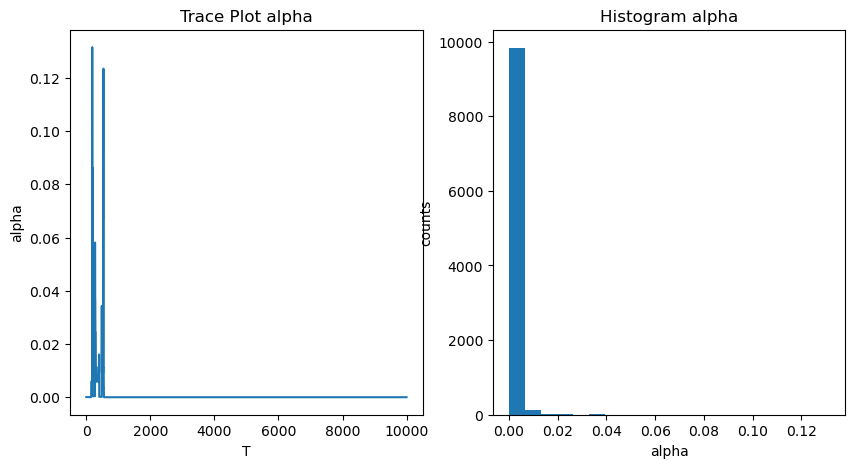

In [16]:
alpha_save = covar_set2_outputs[2]
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(alpha_save[n_burn_in:])
ax[0].set_xlabel('T')
ax[0].set_ylabel('alpha')
ax[0].set_title('Trace Plot alpha')

ax[1].hist(alpha_save[n_burn_in:],bins=20)
ax[1].set_xlabel('alpha')
ax[1].set_ylabel('counts')
ax[1].set_title('Histogram alpha')
plt.show()

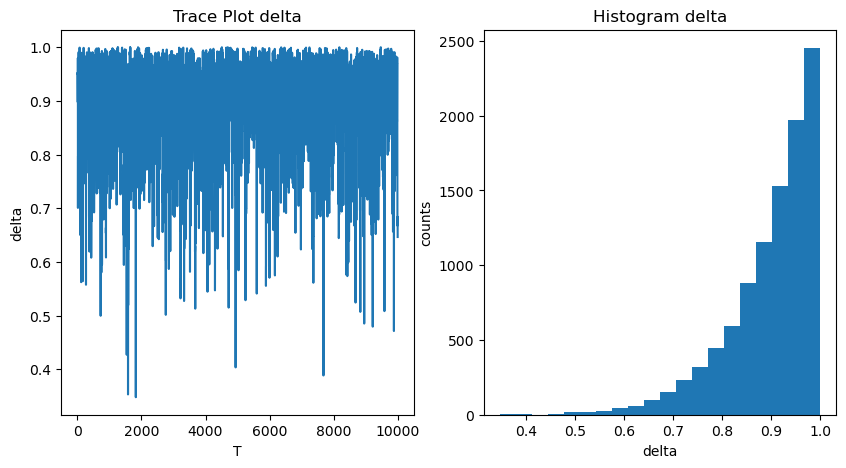

In [17]:
delta_save = covar_set2_outputs[3]
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(delta_save[n_burn_in:])
ax[0].set_xlabel('T')
ax[0].set_ylabel('delta')
ax[0].set_title('Trace Plot delta')

ax[1].hist(delta_save[n_burn_in:],bins=20)
ax[1].set_xlabel('delta')
ax[1].set_ylabel('counts')
ax[1].set_title('Histogram delta')
plt.show()

In [18]:
normalized_sim_mat = calc_hit_matrix(covar_set2_outputs[1],
                                     burn_samples=n_burn_in,
                                     normalize=True)

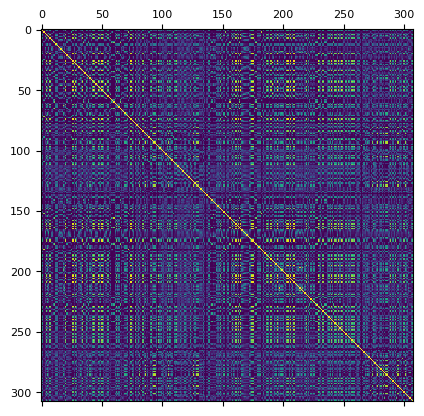

In [50]:
plt.rcParams.update({'font.size': 8})
plt.matshow(normalized_sim_mat)
plt.savefig('Plots/NSW Posterior Similarity Matrix.png')
plt.show()

In [20]:
partition_lengths = [len(np.unique(x)) for x in covar_set2_outputs[1]]
np.mean(partition_lengths[n_burn_in:])

11.7056

In [27]:
agglo_cluster_solution = agglo_cluster(sim_matrix=normalized_sim_mat,
                                       n_clust=8,
                                       linkage_type='average')

In [28]:
#agglo_cluster_solution = covar_set2_outputs[1][-200]

In [30]:
pd.Series(agglo_cluster_solution).value_counts() 

1    97
0    89
6    70
5    32
2    10
3     6
4     2
7     2
dtype: int64

In [31]:
cluster_ids_wanted = list(pd.Series(agglo_cluster_solution).value_counts().index[0:6])
cluster_ids_wanted

[1, 0, 6, 5, 2, 3]

In [32]:
cluster_id_by_size = list(pd.Series(agglo_cluster_solution).value_counts().index)
clus_1 = data.iloc[np.where(agglo_cluster_solution==cluster_id_by_size[0])[0]]
clus_2 = data.iloc[np.where(agglo_cluster_solution==cluster_id_by_size[1])[0]]
clus_3 = data.iloc[np.where(agglo_cluster_solution==cluster_id_by_size[2])[0]]
#clus_4 = data.iloc[np.where(agglo_cluster_solution==cluster_id_by_size[3])[0]]

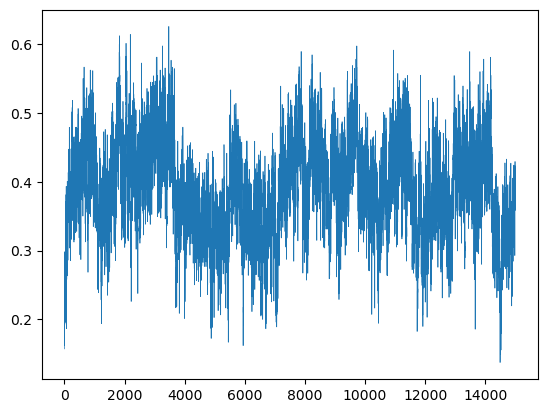

In [34]:
from sklearn.metrics import adjusted_rand_score

ari_scores = []
for i,p in enumerate(partition_save):
    
    ari_scores.append(adjusted_rand_score(p, agglo_cluster_solution))

sim_clusters_samples = np.where(np.array(ari_scores)>0.8)[0]

plt.plot(ari_scores,lw=0.5)

# Predictive

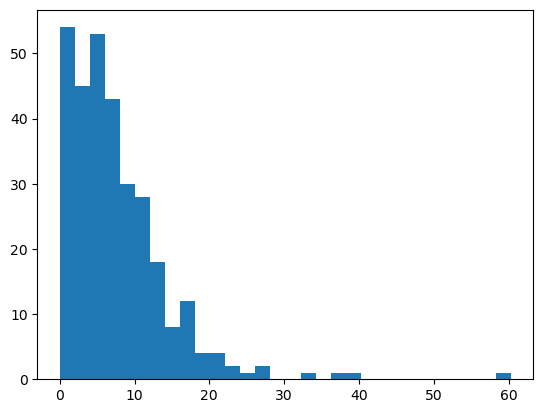

In [35]:
plt.hist(Ys,bins=30)
plt.show()

In [36]:
log_prob_save, partition_save, alpha_save, delta_save, phi_save = covar_set2_outputs

### Loop over conditionally correct params to get clusters

In [37]:
n_data = len(Ys)
y_0 = []
y_1 = [] 
y_pred = []

for g in range(n_burn_in,len(partition_save)):
#for g in sim_clusters_samples:
    
    if g < n_burn_in:
        continue
    
    partition_g = partition_save[g]
    phi_g = phi_save[g]
    
    y_1_g = np.zeros(n_data)
    y_0_g = np.zeros(n_data)
    y_pred_g = np.zeros(n_data)
    for i in range(n_data):
        
        # get stuff
        covars_single = data[covar_single].iloc[i].values
        
        # Actual Y
        actual_input = reg_covariates[i]
        
        if interact_effects:
            y0_inputs = np.concatenate([np.array([1,0]), covars_single, covars_single*0])
            y1_inputs = np.concatenate([np.array([1,1]), covars_single, covars_single*1])
        
        else:
            y0_inputs = np.concatenate([np.array([1,0]), covars_single])
            y1_inputs = np.concatenate([np.array([1,1]), covars_single])   
        
        part_i = partition_g[i]
        phi_i = phi_g[part_i-1]
        
        y0_pred = phi_i @ y0_inputs
        y1_pred = phi_i @ y1_inputs
        yobs_pred = phi_i @ actual_input
        
        y_0_g[i] = y0_pred
        y_1_g[i] = y1_pred
        y_pred_g[i] = yobs_pred
    
    y_1.append(y_1_g)
    y_0.append(y_0_g)
    y_pred.append(y_pred_g)

y_1 = np.array(y_1)
y_0 = np.array(y_0)
y_pred = np.array(y_pred)

In [38]:
hte_samples = y_1 - y_0  
y_1_mean = y_1.mean(0)
y_0_mean = y_0.mean(0)
hte_sample_mean = hte_samples.mean(0)

## Check model fit

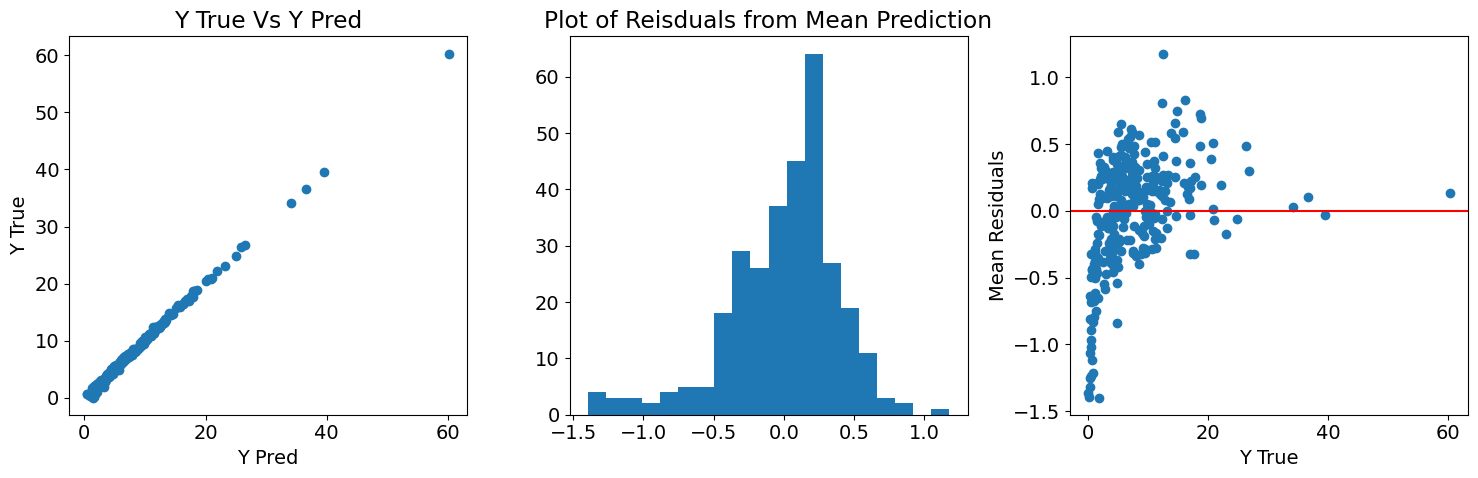

In [52]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].scatter(y_pred.mean(0),Ys)
ax[0].set_xlabel('Y Pred')
ax[0].set_ylabel('Y True')
ax[0].set_title('Y True Vs Y Pred')

residuals_mean = Ys - y_pred.mean(0)
ax[1].hist(residuals_mean,bins=20)
ax[1].set_title("Plot of Reisduals from Mean Prediction")

ax[2].scatter(Ys, residuals_mean)
ax[2].set_xlabel('Y True')
ax[2].set_ylabel('Mean Residuals')
ax[2].axhline(0, color='red')

plt.savefig('Plots/NSW_diagnostics.png')
plt.tight_layout()
plt.show()

## Plot HTE of Samples

In [41]:
col_map = ['red','green','blue','yellow','purple','black','tab:orange','tab:blue','tab:green','tab:red']

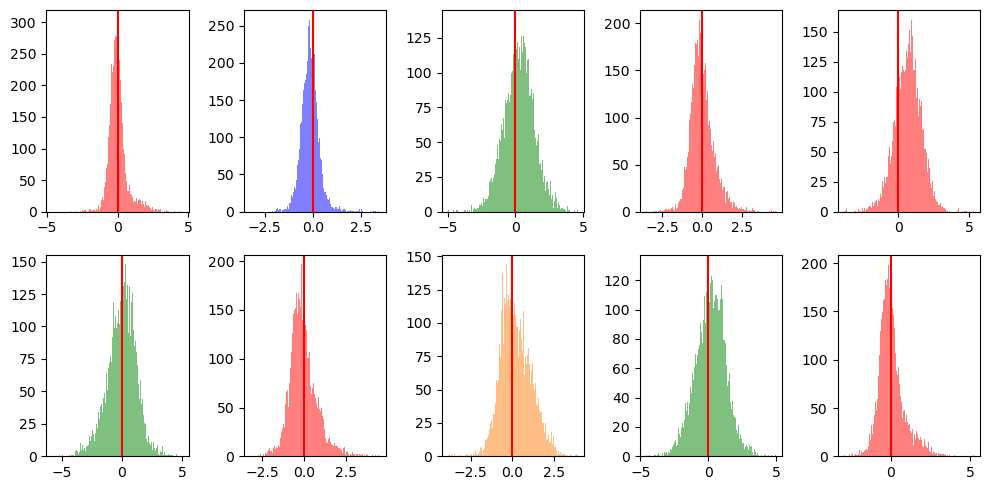

In [42]:
fig,ax = plt.subplots(2,5,figsize=(10,5))

plot_vals = np.random.choice(list(range(300)),10)

i = 0
for j in range(5):
    for k in range(2):
        
        point_clus = agglo_cluster_solution[i]
        
        ax[k,j].hist(hte_samples[:,plot_vals[i]],bins=300,
                     color=col_map[agglo_cluster_solution[i]],alpha=0.5)
        
        ax[k,j].axvline(0,color='red')
        i+=1
plt.tight_layout()
plt.show()

Calculate some Stats

In [43]:
col_map = ['red','green','blue','yellow','purple','black','tab:orange','tab:blue','tab:green','tab:red']

In [54]:
plt.rcParams.update({'font.size': 14})

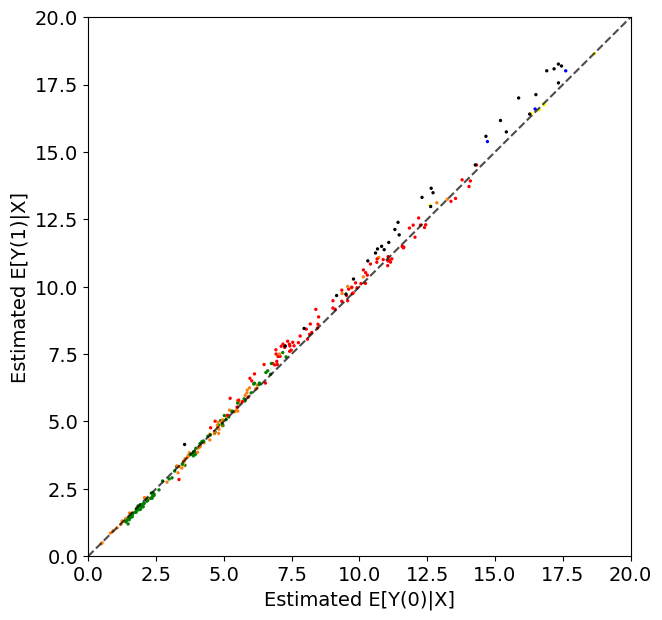

In [55]:
fig, ax = plt.subplots(figsize=(7,7))

ax_min = min(min(y_0_mean),min(y_1_mean)) - 5
ax_max = max(max(y_0_mean),max(y_1_mean)) + 5

ax.axline([0, 0], [1, 1], color='black', alpha=0.7, linestyle='--')

ax.scatter(y_0_mean, y_1_mean, color=[col_map[c] for c in agglo_cluster_solution], s=2)

ax.set_xlabel('Estimated E[Y(0)|X]')
ax.set_ylabel('Estimated E[Y(1)|X]')

ax.set_xlim(ax_min, ax_max)
ax.set_ylim(ax_min, ax_max)

ax.set_xlim(0, 20)
ax.set_ylim(0, 20)
plt.savefig('Plots/NSW_output_scatted.png')
plt.show()

In [56]:
col_map = ['red','green','blue','yellow','purple','black','tab:orange','tab:blue','tab:green','tab:red']

In [57]:
import seaborn as sns

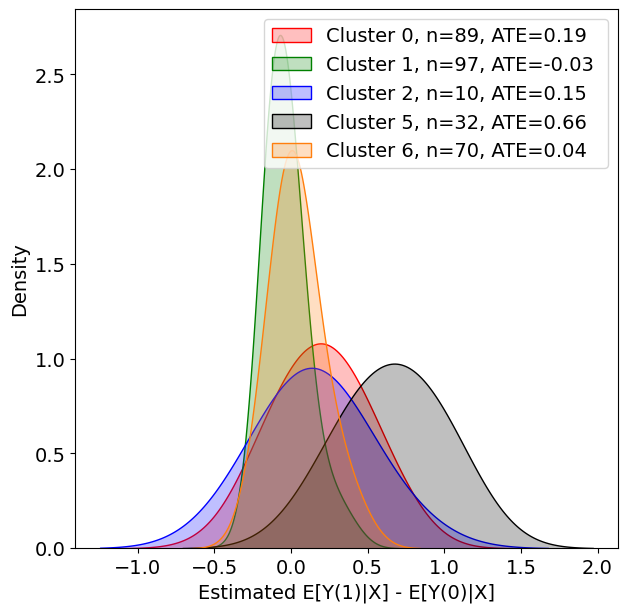

In [60]:
hte_sample_mean = hte_samples.mean(0)

fig, ax = plt.subplots(figsize=(7,7))

for i,c in enumerate(np.unique(agglo_cluster_solution)):
    
    sample_htes = hte_sample_mean[np.where(agglo_cluster_solution==c)[0]]
    n_c = len(sample_htes)
    if n_c < 10:
        continue
    #ax.hist(sample_htes,bins=5, color=col_map[i], alpha=0.5)
    lab = f'Cluster {c}, n={n_c}, ATE={np.mean(sample_htes):.2f} '

    sns.kdeplot(data=sample_htes,color=col_map[i], ax=ax,fill=True,label=lab,bw_adjust=2)
    #ax.axvline(np.mean(sample_htes),color=col_map[i])

ax.set_xlabel('Estimated E[Y(1)|X] - E[Y(0)|X]')
ax.legend()
plt.savefig('Plots/NSW_output_histogram.png')
plt.show()

In [1765]:
clu_check = clus_1
print(len(clu_check))
clu_check.loc[clu_check['treat']==1,'earning_log'].mean() - \
clu_check.loc[clu_check['treat']==0,'earning_log'].mean()

92


0.08822398444773594

In [1766]:
y_1_mean = y_1[0:,:].mean(0)
y_0_mean = y_0[0:,:].mean(0)

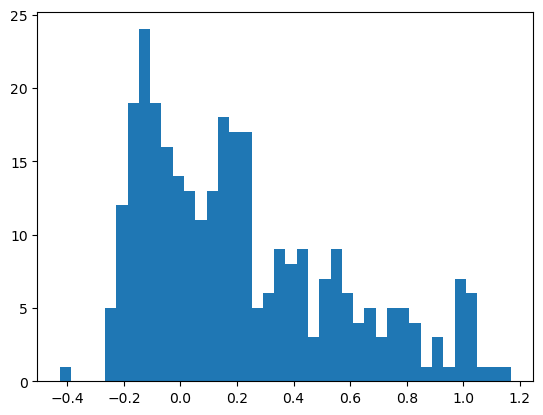

In [1767]:
# HTE Mean Estimates
plt.hist(y_1_mean - y_0_mean, bins=40)
plt.show()

In [1507]:
# ATE estimates
nsw_data.loc[nsw_data['treat']==1,'re78'].mean() - \
nsw_data.loc[nsw_data['treat']==0,'re78'].mean()

1794.3423818501024

In [ ]:
mod = smf.ols(formula='final_income ~ treat', data=clus_3)
res = mod.fit()
print(res.summary())